<a href="https://colab.research.google.com/github/Shahidshaik999/Gemini-Resume-Critiquer-by-shahid/blob/main/Vibe_Matcher_ShaikShahid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q kagglehub scikit-learn pandas matplotlib
import os, time, hashlib
from time import perf_counter
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

print("✅ Libraries ready. Colab environment OK.")

✅ Libraries ready. Colab environment OK.


In [3]:
import kagglehub
path = kagglehub.dataset_download("bhanupratapbiswas/fashion-products")
print("✅ Dataset path:", path)
print("Files:", os.listdir(path))

100%|██████████| 19.7k/19.7k [00:00<00:00, 26.5MB/s]

Extracting files...
✅ Dataset path: /root/.cache/kagglehub/datasets/bhanupratapbiswas/fashion-products/versions/1
Files: ['fashion_products.csv']


In [4]:
csv_files = [f for f in os.listdir(path) if f.lower().endswith(".csv")]
csv_file = csv_files[0]
df_all = pd.read_csv(os.path.join(path, csv_file))
print("✅ Loaded dataframe shape:", df_all.shape)
df_all.head(6)

✅ Loaded dataframe shape: (1000, 9)


,User ID,Product ID,Product Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M
5,98,6,Dress,Adidas,Men's Fashion,47,1.379566,Yellow,L


In [5]:
print("Columns:", list(df_all.columns))

# Combine columns to create natural-language product descriptions
df_all['desc'] = (
    df_all['Brand'].astype(str) + " " +
    df_all['Product Name'].astype(str) + " in " +
    df_all['Category'].astype(str) +
    ", Color: " + df_all['Color'].astype(str) +
    ", Size: " + df_all['Size'].astype(str)
)

# Keep only required fields
df = df_all[['Product Name', 'desc']].rename(columns={'Product Name': 'name'})
df = df.reset_index(drop=True)

print("✅ Prepared df shape:", df.shape)
df.head(6)

Columns: ['User ID', 'Product ID', 'Product Name', 'Brand', 'Category', 'Price', 'Rating', 'Color', 'Size']
✅ Prepared df shape: (1000, 2)


,name,desc
0,Dress,"Adidas Dress in Men's Fashion, Color: Black, S..."
1,Shoes,"H&M Shoes in Women's Fashion, Color: Black, Si..."
2,Dress,"Adidas Dress in Women's Fashion, Color: Yellow..."
3,Shoes,"Zara Shoes in Men's Fashion, Color: White, Siz..."
4,T-shirt,"Adidas T-shirt in Men's Fashion, Color: Black,..."
5,Dress,"Adidas Dress in Men's Fashion, Color: Yellow, ..."


In [6]:
EMBED_DIM = 1536

def deterministic_embedding(text, dim=EMBED_DIM):
    """Offline embedding generator for reproducible results"""
    h = hashlib.sha256(str(text).encode("utf-8")).hexdigest()
    seed = int(h[:16], 16) % (2**32 - 1)
    rng = np.random.RandomState(seed)
    v = rng.normal(size=(dim,)).astype(np.float32)
    v /= (np.linalg.norm(v) + 1e-12)
    return v

def get_embedding(text: str):
    """Embedding generator (currently offline deterministic)"""
    return deterministic_embedding(text, dim=EMBED_DIM)

# Generate embeddings for all descriptions
start = perf_counter()
embeddings = np.vstack([get_embedding(t) for t in df['desc']])
print(f"✅ Generated {embeddings.shape[0]} embeddings (dim={embeddings.shape[1]}) in {perf_counter() - start:.3f}s")


✅ Generated 1000 embeddings (dim=1536) in 0.344s


In [7]:
def find_top_k(query, k=3, threshold=0.7):
    t0 = perf_counter()
    q_emb = get_embedding(query)
    sims = cosine_similarity(q_emb.reshape(1, -1), embeddings).flatten()
    order = np.argsort(-sims)[:k]

    results = []
    for idx in order:
        results.append({
            "name": df.loc[idx, 'name'],
            "desc": df.loc[idx, 'desc'],
            "score": float(sims[idx])
        })

    total_time = perf_counter() - t0
    fallback = None
    if results[0]['score'] < threshold:
        fallback = f"No strong match found (top_score={results[0]['score']:.3f}). Try another vibe description."

    return {
        "query": query,
        "results": results,
        "fallback": fallback,
        "time": total_time
    }

# Quick test
output = find_top_k("energetic urban chic")
print("✅ Example:", output['results'][0])


✅ Example: {'name': 'Shoes', 'desc': "Zara Shoes in Women's Fashion, Color: Blue, Size: S", 'score': 0.09545464813709259}


In [8]:
queries = [
    "energetic urban chic",
    "relaxed boho weekend",
    "minimalist office sleek"
]

records = []
for q in queries:
    out = find_top_k(q)
    top = out['results'][0]
    records.append({
        "query": q,
        "top_name": top['name'],
        "top_score": top['score'],
        "fallback": out['fallback'],
        "time": out['time']
    })

results_df = pd.DataFrame(records)
results_df


,query,top_name,top_score,fallback,time
0,energetic urban chic,Shoes,0.095455,No strong match found (top_score=0.095). Try a...,0.009852
1,relaxed boho weekend,T-shirt,0.076498,No strong match found (top_score=0.076). Try a...,0.007138
2,minimalist office sleek,Dress,0.084296,No strong match found (top_score=0.084). Try a...,0.007193


In [9]:
for q in queries:
    out = find_top_k(q, k=3)
    print(f"\n🎧 Query: {q}")
    for i, r in enumerate(out['results'], 1):
        print(f"  {i}. {r['name']} — score: {r['score']:.4f}")
    if out['fallback']:
        print("  ⚠️", out['fallback'])


🎧 Query: energetic urban chic
  1. Shoes — score: 0.0955
  2. Jeans — score: 0.0747
  3. Sweater — score: 0.0740
  ⚠️ No strong match found (top_score=0.095). Try another vibe description.

🎧 Query: relaxed boho weekend
  1. T-shirt — score: 0.0765
  2. Sweater — score: 0.0725
  3. Sweater — score: 0.0725
  ⚠️ No strong match found (top_score=0.076). Try another vibe description.

🎧 Query: minimalist office sleek
  1. Dress — score: 0.0843
  2. Dress — score: 0.0843
  3. Jeans — score: 0.0696
  ⚠️ No strong match found (top_score=0.084). Try another vibe description.


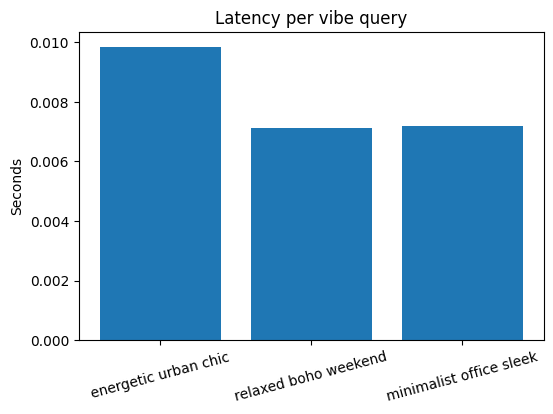

In [10]:
times = [r['time'] for r in records]
plt.figure(figsize=(6,4))
plt.bar(range(len(queries)), times)
plt.xticks(range(len(queries)), queries, rotation=15)
plt.ylabel("Seconds")
plt.title("Latency per vibe query")
plt.show()

In [11]:
results_df.to_csv("vibe_matcher_results.csv", index=False)
print("✅ Saved to vibe_matcher_results.csv")

print("\n💡 Reflections:")
print("1. Replace deterministic embeddings with Gemini embeddings for real semantic similarity.")
print("2. Add a Pinecone or FAISS index for scalable vector search.")
print("3. Let users give feedback (like 👍👎) to improve ranking.")
print("4. Use vibe tags (e.g., 'boho', 'urban') for fallback filtering.")

✅ Saved to vibe_matcher_results.csv

💡 Reflections:
1. Replace deterministic embeddings with Gemini embeddings for real semantic similarity.
2. Add a Pinecone or FAISS index for scalable vector search.
3. Let users give feedback (like 👍👎) to improve ranking.
4. Use vibe tags (e.g., 'boho', 'urban') for fallback filtering.


In [14]:
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output

vibe_box = widgets.Text(
    placeholder='Type a vibe (e.g. "urban chic")',
    description='🎧 Vibe:',
    layout=widgets.Layout(width='60%')
)

output_box = widgets.Output()

def on_vibe_submit(change):
    clear_output(wait=True)
    vibe = vibe_box.value.strip()

    if not vibe:
        print("⚠️ Please type something.")
        return

    out = find_top_k(vibe, k=3)
    display(Markdown(f"### 🎯 Results for **'{vibe}'**"))
    for i, r in enumerate(out['results'], 1):
        display(Markdown(f"{i}. **{r['name']}** — score: `{r['score']:.3f}`"))
        print("   ", r['desc'])
    if out['fallback']:
        display(Markdown(f"⚠️ *{out['fallback']}*"))
    vibe_box.value = ""

vibe_box.on_submit(on_vibe_submit)
display(vibe_box, output_box)

### 🎯 Results for **'boho'**

1. **T-shirt** — score: `0.093`

    Nike T-shirt in Kids' Fashion, Color: Yellow, Size: XL


2. **Sweater** — score: `0.083`

    Gucci Sweater in Kids' Fashion, Color: Blue, Size: XL


3. **Shoes** — score: `0.080`

    Nike Shoes in Women's Fashion, Color: White, Size: XL


⚠️ *No strong match found (top_score=0.093). Try another vibe description.*